<a href="https://colab.research.google.com/github/natasha-kolom/Machine_learning/blob/main/HW_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

In [4]:
data = pd.read_csv("train.csv.zip")

In [5]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
display(data.head())

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



<Axes: xlabel='item,store'>

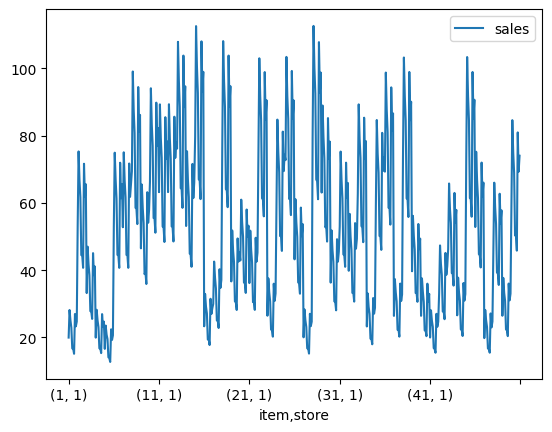

In [8]:
data.groupby(['item','store']).mean().plot()

In [6]:
grouped_df = data.groupby(['item', 'store'])['sales'].mean().reset_index()

<ipython-input-10-a05eb1a8f4c5>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=grouped_df, x='item', y='sales', hue='store', ci=None)


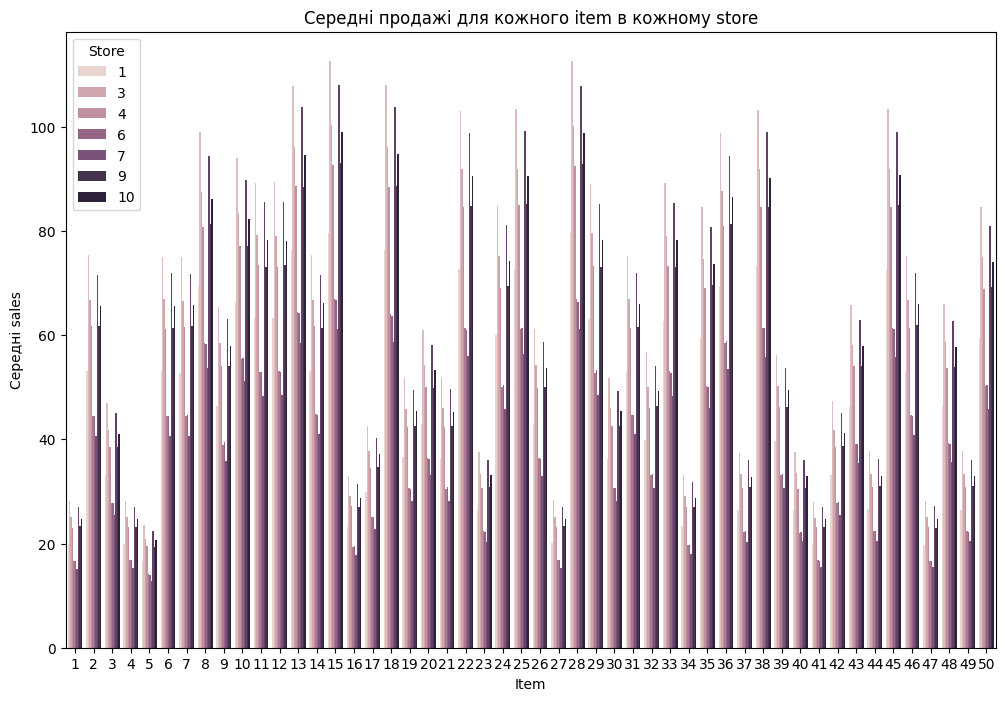

In [10]:
plt.figure(figsize=(12, 8))
sns.barplot(data=grouped_df, x='item', y='sales', hue='store', ci=None)
plt.title('Середні продажі для кожного item в кожному store')
plt.xlabel('Item')
plt.ylabel('Середні sales')
plt.legend(title='Store')
plt.show()

In [1]:
def target_summary_with_cat(dataframe, target, categorical_col):
    summary_df = dataframe.groupby(categorical_col)[target].mean().reset_index()
    summary_df.columns = [categorical_col, "TARGET_MEAN"]

    print(summary_df, end="\n\n\n")

    # Create histogram
    plt.figure(figsize=(15, 6))
    plt.bar(summary_df[categorical_col].astype(str), summary_df["TARGET_MEAN"], color='skyblue')
    plt.xlabel(categorical_col)
    plt.ylabel(target)
    plt.title(f"{target} mean for {categorical_col}")
    plt.xticks(rotation=45)
    plt.show()

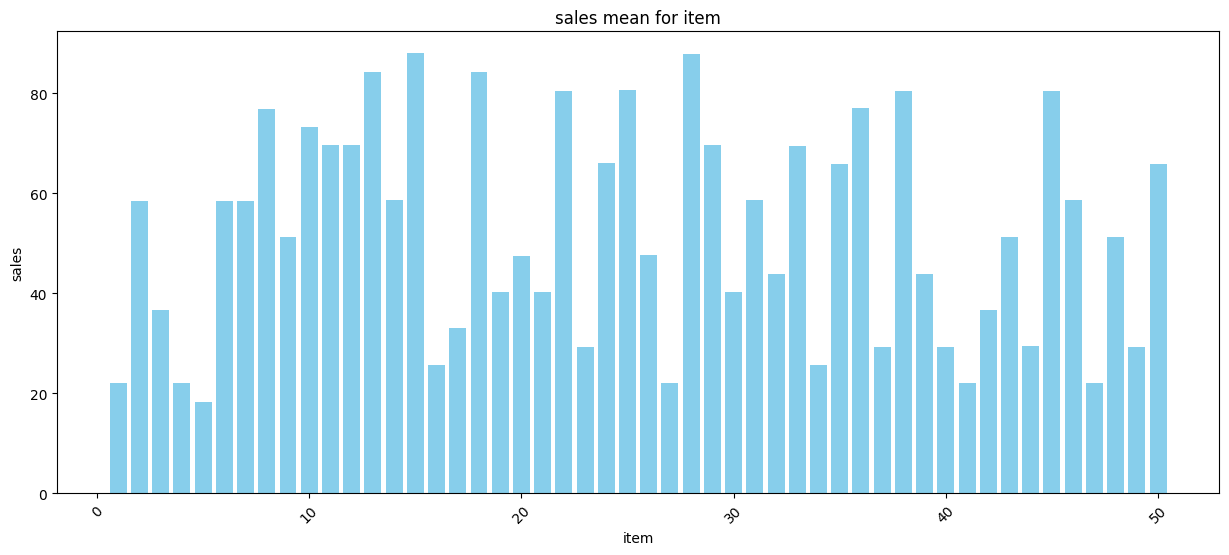

In [17]:

grouped_df = data.groupby(['item'])['sales'].mean().reset_index()
plt.figure(figsize=(15, 6))
plt.bar(grouped_df['item'], grouped_df['sales'], color='skyblue')
plt.xlabel('item')
plt.ylabel('sales')
plt.title(f"sales mean for item")
plt.xticks(rotation=45)
plt.show()

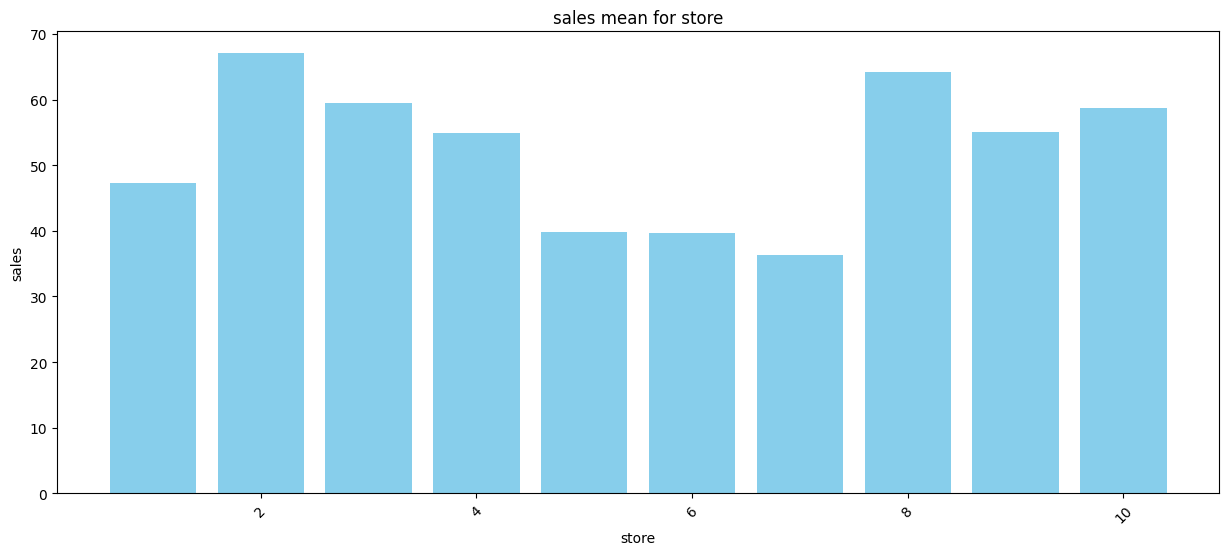

In [18]:
grouped_df = data.groupby(['store'])['sales'].mean().reset_index()
plt.figure(figsize=(15, 6))
plt.bar(grouped_df['store'], grouped_df['sales'], color='skyblue')
plt.xlabel('store')
plt.ylabel('sales')
plt.title(f"sales mean for store")
plt.xticks(rotation=45)
plt.show()

**Спостереження** Помічена динаміка, що якщо товар погано продається, то він погано продається у всих магазинах. Більш популярні товари добре продаються у всіх магазинах

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [13]:
df_1 = data[(data['store']==1) & (data['item']==1)]

In [14]:
df_1[df_1.index.year==2013]['sales']

,sales
date,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10
...,...
2013-12-27,18
2013-12-28,17
2013-12-29,14


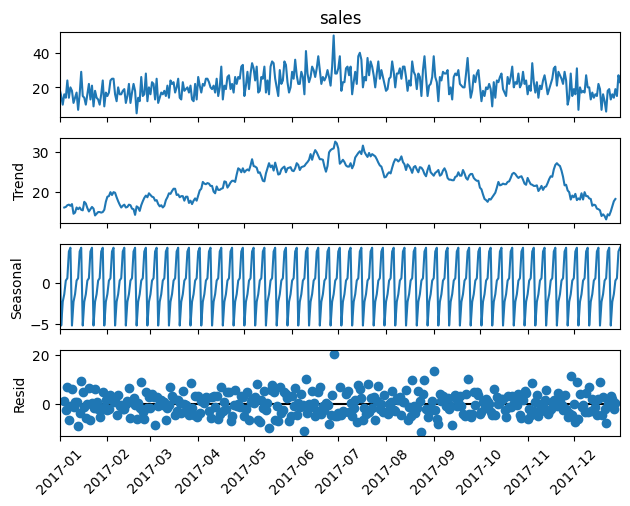

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Візуалізація адитивної декомпозиції для часового ряду
decomposition_plot_multi = seasonal_decompose(df_1[df_1.index.year==2017]['sales'],
                                              model='additive')
decomposition_plot_multi.plot()
plt.xticks(rotation=45)
plt.show()

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [17]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 336.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 40.3 MB/s eta 0:0

In [18]:
from darts import TimeSeries

# Завантаження даних в darts
series = TimeSeries.from_dataframe(df_1, value_cols='sales')

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

In [19]:
train, test = series.split_before(pd.Timestamp('2017-10-01'))

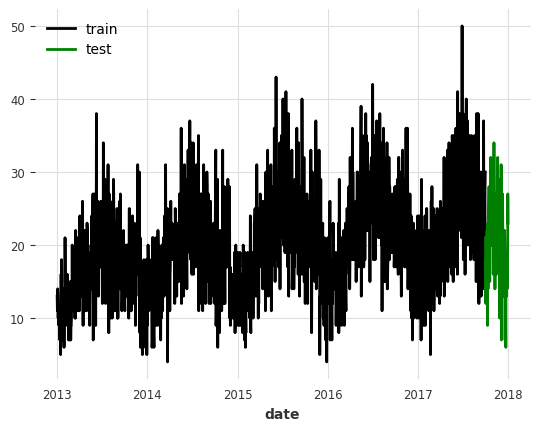

In [20]:
train.plot(label='train')
test.plot(label='test', color='green')
plt.legend()
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

<Figure size 1000x600 with 0 Axes>

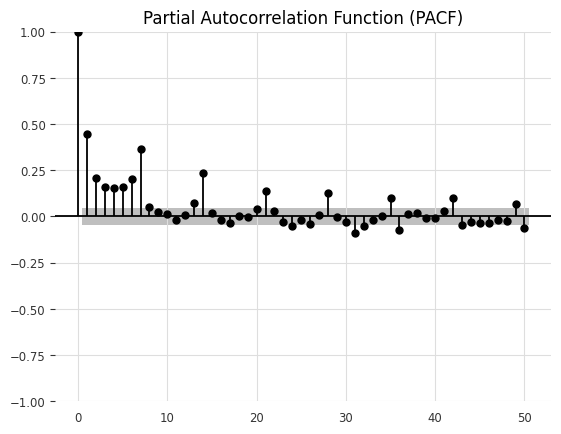

In [21]:
from statsmodels.graphics.tsaplots import plot_pacf

# Візуалізація часткової автокореляційної функції (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(series.values(), lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

**Спостереження**
Значущими є лаги з 1 по 8, а також 14, 15, 22, 25, 29, 32, 33, 36, 37, 43, 49, 50. Кореляція на цих лагах залишається значущою, навіть усунувши вплив проміжних лагів.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

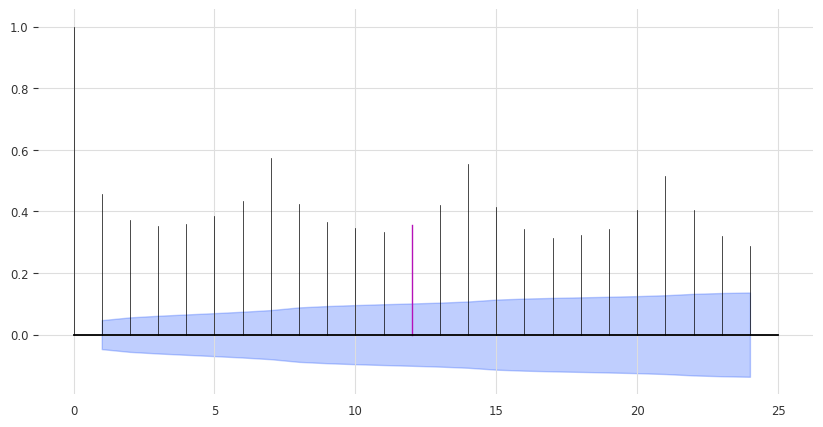

In [22]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05, max_lag=24)

ACF показує пік при x = 7, 14 та 21, що вказує на сезональність раз на 7 місяців, можнасказати що це піврічна сезональність

In [23]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


<Axes: xlabel='date'>

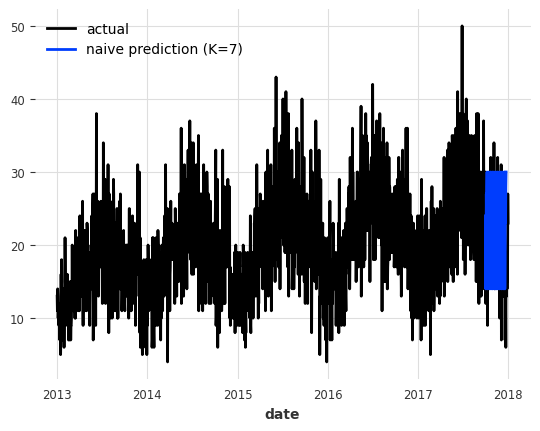

In [24]:
from darts.models import NaiveSeasonal

seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(84)

series.plot(label="actual")
seasonal_forecast.plot(label="naive prediction (K=7)")

<Axes: xlabel='date'>

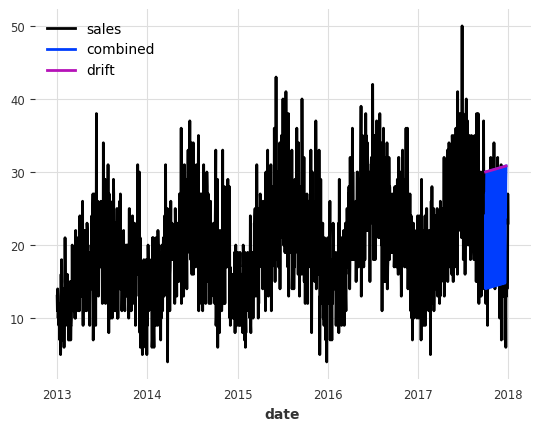

In [25]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(84)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

**Спостереження** Модель не точна і погано прогнозує, я пробувала встановлювати сезональність 7, 14 та 21 - результати неточні в усіх випадках

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [26]:
from darts.metrics import mape

print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(series, combined_forecast):.2f}%."
)

Mean absolute percentage error for the combined naive drift + seasonal: 40.10%.


**Спостереження** Як і було видно на картинці, можель прогнозує погано, що і підтверджується помилкою в 40 відсотків

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [27]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

def enrich_with_date_features(df):
  # Feature Extraction
  df["dayofweek"] = df['date'].dt.dayofweek
  df["quarter"] = df['date'].dt.quarter
  df["month"] = df['date'].dt.month
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  df["dayofmonth"] = df['date'].dt.day
  return df

# Додавання ознак дати
train_transformed = enrich_with_date_features(train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(test.pd_dataframe().reset_index())

# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
test_transformed = scaler.transform(test)

# Побудова моделі XGBoost
model = XGBModel(
    lags=7,  # Використання останніх 7 спостережень для прогнозування
    output_chunk_length=1,  # Прогнозування на 1 крок вперед
    n_estimators=100,  # Кількість дерев у моделі
    max_depth=3,  # Максимальна глибина кожного дерева
    learning_rate=0.1,  # Коефіцієнт навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8  # Частка ознак, що використовуються для кожного дерева
)

# Тренування моделі
model.fit(train_transformed)
pred = model.predict(42)
pred.values()

array([[0.43286052],
       [0.34129617],
       [0.40169948],
       [0.4591532 ],
       [0.4186582 ],
       [0.48570073],
       [0.49553263],
       [0.3970556 ],
       [0.3576523 ],
       [0.40402865],
       [0.4326274 ],
       [0.42061755],
       [0.43970364],
       [0.4412779 ],
       [0.40433928],
       [0.35336587],
       [0.3782552 ],
       [0.37804422],
       [0.3862937 ],
       [0.38640472],
       [0.387127  ],
       [0.38798156],
       [0.34037673],
       [0.3385215 ],
       [0.33203983],
       [0.32996786],
       [0.33833057],
       [0.34266955],
       [0.3433713 ],
       [0.34078607],
       [0.34078607],
       [0.34078607],
       [0.34078607],
       [0.34078607],
       [0.34078607],
       [0.34078607],
       [0.34078607],
       [0.34078607],
       [0.34078607],
       [0.34078607],
       [0.34078607],
       [0.34078607]], dtype=float32)

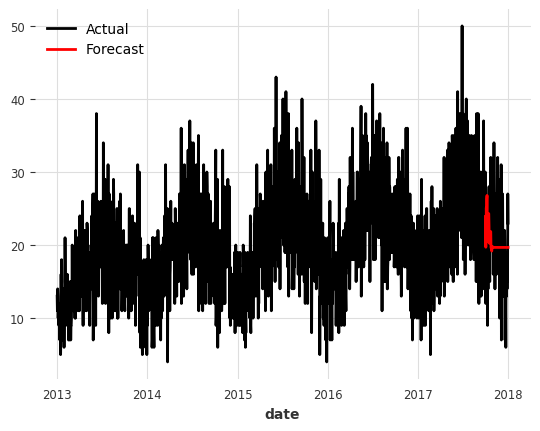

model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 29.08%


In [28]:
forecast = scaler.inverse_transform(model.predict(len(test)))
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()
mape_ = mape(test, forecast)
print(f"model {model} obtains MAPE: {mape_:.2f}%")

**Спостереження**
Якість моделі вже краще, ніж у наївної, але все одно помилка ще велика

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

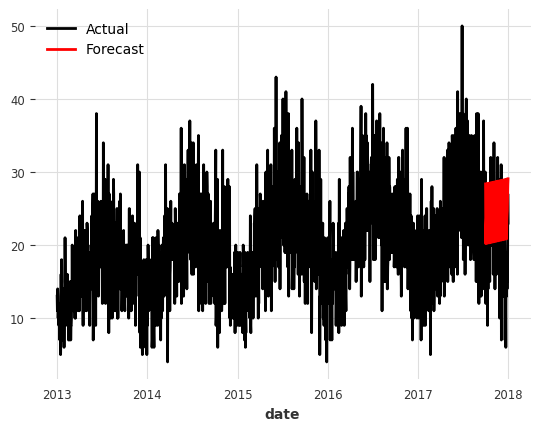

model ExponentialSmoothing() obtains MAPE: 39.01%


In [29]:
from darts.models import ExponentialSmoothing, AutoARIMA, Theta

def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")

def plot_results(series, forecast):
  # Візуалізація результатів
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);

model = ExponentialSmoothing()
fit_and_plot(model, series, train, test)

**Спостереження**
Ця модель показує себе гірше ніж XGBoost

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


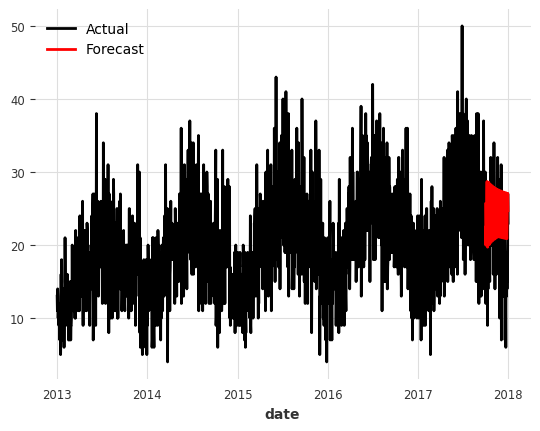

model ARIMA(p=21, q=7) obtains MAPE: 37.09%


In [30]:
from darts.models import ARIMA
model = ARIMA(p=21, d=1, q=7)
fit_and_plot(model, series, train, test)

**Спостереження**
Якість моделі трішки краща, ніж ExponentialSmoothing, але все-одно гірша за XGBoost

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

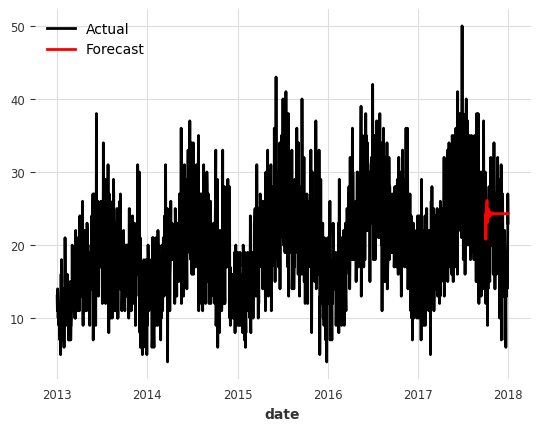

model AutoARIMA(start_p=7, max_p=21, start_q=1) obtains MAPE: 39.53%


In [31]:
# Побудова та тренування моделі AutoArima
model = AutoARIMA(start_p=7, max_p=21, start_q=1)
fit_and_plot(model, series, train, test)

**Спостереження**
Результати порівняно з попередньою моделлю не покращились

14. Натренуйте модель Prophet та зробіть висновок про її якість.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeod8rs_r/8jz04q4w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeod8rs_r/tkk68b0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45563', 'data', 'file=/tmp/tmpeod8rs_r/8jz04q4w.json', 'init=/tmp/tmpeod8rs_r/tkk68b0m.json', 'output', 'file=/tmp/tmpeod8rs_r/prophet_model_gfqwc6s/prophet_model-20240817010325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:03:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:03:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


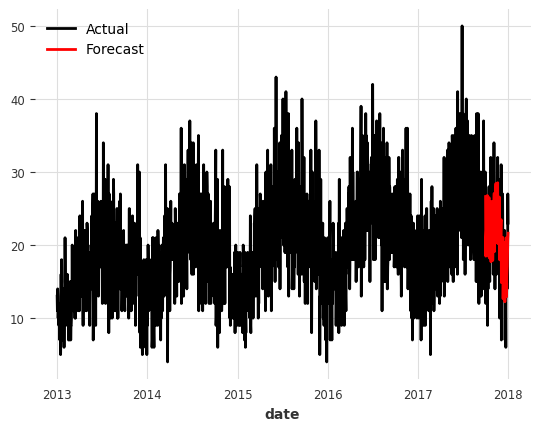

model Prophet() obtains MAPE: 23.80%


In [32]:
from darts.models import Prophet

# Побудова та тренування моделі Prophet
model = Prophet()
fit_and_plot(model, series, train, test)

**Спостереження**
Ця модель дала найкращий результат

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

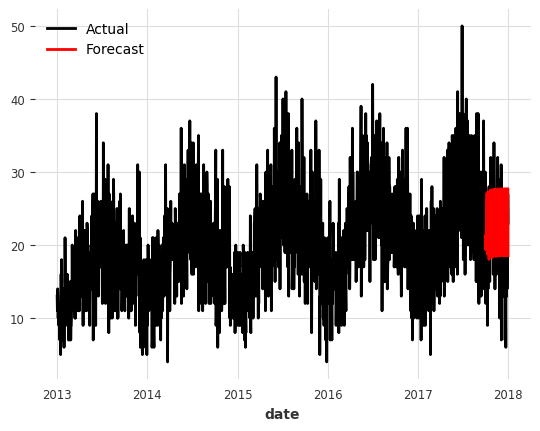

model RNNModel(model=LSTM, input_chunk_length=7, n_epochs=300) obtains MAPE: 37.71%


In [34]:
from darts.models import RNNModel

# Побудова та тренування моделі LSTM
model = RNNModel(model='LSTM', input_chunk_length=7, n_epochs=300)
fit_and_plot(model, series, train, test)

**Спостереження** Ця модель дала гірший результат ніж попередня

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [35]:
# наша найкраща модель

model =  Prophet()
model.fit(train)
forecast = model.predict(len(test))
eval_forecast(model, test, forecast);


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeod8rs_r/wgro7pte.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeod8rs_r/uvkn3xys.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89322', 'data', 'file=/tmp/tmpeod8rs_r/wgro7pte.json', 'init=/tmp/tmpeod8rs_r/uvkn3xys.json', 'output', 'file=/tmp/tmpeod8rs_r/prophet_modelqxwqi7qn/prophet_model-20240817013019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:30:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:30:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


model Prophet() obtains MAPE: 23.80%


  0%|          | 0/365 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeod8rs_r/u1zojakn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeod8rs_r/t4zo2et6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44560', 'data', 'file=/tmp/tmpeod8rs_r/u1zojakn.json', 'init=/tmp/tmpeod8rs_r/t4zo2et6.json', 'output', 'file=/tmp/tmpeod8rs_r/prophet_modelipvkoxl9/prophet_model-20240817013155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 1/365 [00:00<03:45,  1.61it/s]INFO:prophet:Disabling daily seasonality. Run prophet wi

MAPE = 20.89%


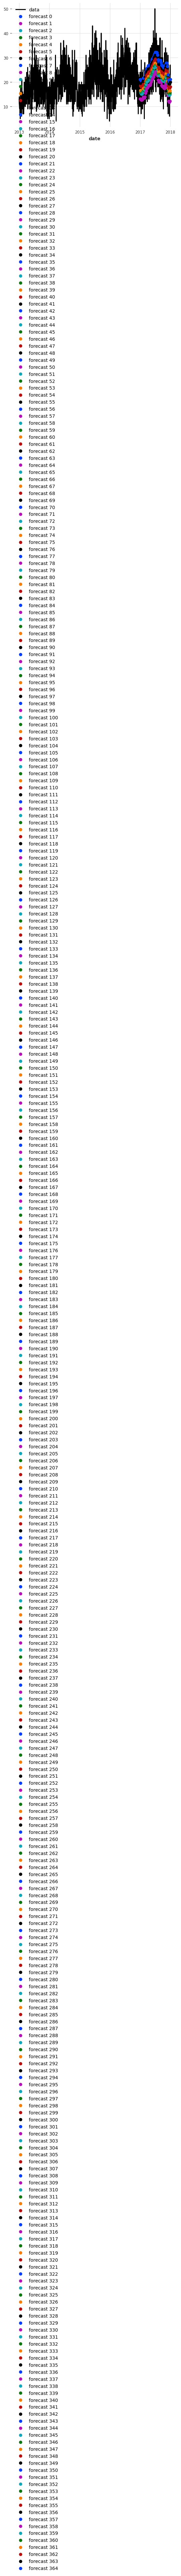

In [36]:
hfc_params = {
    "series": series,
    "start": pd.Timestamp("2017-01-01"),  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 1,
    "verbose": True,
}

historical_fcast_all = model.historical_forecasts(last_points_only=False, stride=1, **hfc_params)

series.plot(label="data")
for idx, hfc in enumerate(historical_fcast_all):
    hfc.plot(label=f"forecast {idx}")

from darts import concatenate
historical_fcast_all = concatenate(historical_fcast_all, axis=0)
print(f"MAPE = {mape(series, historical_fcast_all):.2f}%")

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

**Спостереження**
В нашій моделі найкраще спрацювала модель Prophet, для прогнозування продажів в 10 магазинах можна було б використати цю модель і тренувати окремо для кожного айтему в кожному магазині. Я розумію, що цей підхід досить ресурснозатратний. Тому інший варіант - натренувати модель, наприклад XGBoost на всих даних, що дозволить виявити загальні паттерни продажів для всіх 50 айтемів в 10 магазинах.